In [ ]:
import pandas as pd
import numpy as np
import os
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import xgboost as xgb
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, mean_absolute_error
from sklearn.dummy import DummyClassifier


ModuleNotFoundError: No module named 'scripts'

In [123]:
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x).replace(',', ' '))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [124]:
db_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'data_cpv.csv')

data = pd.read_csv(db_path)

## Process and delete outliers

In [125]:
data = data[data['montant'] <= 999999999]
data = data[data['montant'] >= 20000]

In [126]:
data

,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,origineFrance,lieuExecution_code,lieuExecution_typeCode,idAccordCadre,source_open_data,codeCPV_FR,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5
0,2154005160001320242024-LOT04,20242024-LOT04,Marché,21540051600013,COMMUNE DE BATILLY,215 400 516,78885470100018,SIRET,ACOMETAL,788 854 701,...,NaN,54980,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de charpente,45000000,45200000,45260000,45261000
1,243500667002882021M226MO,2021M226MO,Marché,24350066700288,CC VAL D'ILLE-AUBIGNE,243 500 667,38373211200032,SIRET,UNIVERS,383 732 112,...,NaN,35520,Code postal,NaN,data.gouv.fr decp-2024.json,Services d'architecture,71000000,71200000,71200000,71200000
2,249710047000472024SS_PRD_TRV,2024SS_PRD_TRV,Marché,24971004700047,COMMUNAUTE DE COMMUNES DE MARIE GALANTE,249 710 047,43387249600016,SIRET,COTRAM B.T.P.,433 872 496,...,NaN,97112,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de construction de stations d'épuratio...,45000000,45200000,45230000,45232000
3,6254801990001124-0806-L2,24-0806-L2,Marché,62548019900011,"LA MAISON POUR TOUS, SOCIETE ANONYME COOPERATI...",625 480 199,55204695502544,SIRET,ENGIE ENERGIE SERVICES,552 046 955,...,NaN,39,Code département,NaN,data.gouv.fr decp-2024.json,Services de réparation et d'entretien de chauf...,50000000,50700000,50720000,50720000
4,20002563300013202424011BCR,202424011BCR,Marché,20002563300013,SI DE RESTAURATION COLLECTIVE,200 025 633,47698032100238,SIRET,POMONA EPISAVEURS,476 980 321,...,0,45800,Code postal,NaN,data.gouv.fr decp-2025-04.json,Produits alimentaires divers,15000000,15800000,15800000,15800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299665,243000643000452024240072,2024240072,Marché,24300064300045,COMMUNAUTE AGGLO NIMES METROPOLE,243 000 643,79386502300055,SIRET,SERVICES MAINTENANCE ENERGIES,793 865 023,...,NaN,30947,Code postal,NaN,data.gouv.fr decp-2024.json,Services de réparation et d'entretien de chaud...,50000000,50500000,50530000,50531000
299666,2133016250001720230231110,20230231110,Marché,21330162500017,COMMUNE D'EYSINES,213 301 625,44010434700032,SIRET,L.T.B. AQUITAINE,440 104 347,...,NaN,33320,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de peinture,45000000,45400000,45440000,45442000
299667,25440109400068202323_006_02,202323_006_02,Marché,25440109400068,SYNDICAT MIXTE ATLANTIC'EAU,254 401 094,42856174000138,SIRET,CISE TP,428 561 740,...,NaN,44100,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux relatifs aux conduites d'alimentation ...,45000000,45200000,45230000,45232000
299668,219711132000152022I772-4,2022I772-4,Marché,21971113200015,COMMUNE DU GOSIER,219 711 132,41347003000029,SIRET,SOCIETE GUADELOUPEENNE DE TRAVAUX D'ENVIRONNEMENT,413 470 030,...,0,97190,Code postal,NaN,data.gouv.fr decp-2025-01.json,Location de faucheuses ou de matériel agricole...,77000000,77100000,77110000,77112000


<Axes: xlabel='codeCPV_2', ylabel='montant'>

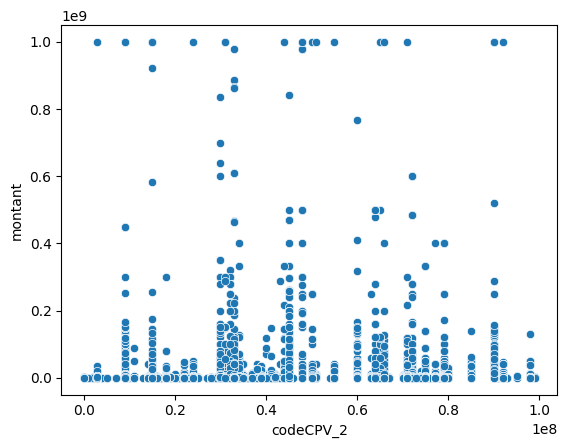

In [127]:
sns.scatterplot(data, x= 'codeCPV_2', y= 'montant')

In [128]:
data.groupby('codeCPV_2').size()

codeCPV_2
0            281
1000000        9
2000000        8
3000000     1635
4000000        1
            ... 
92000000    2519
93000000      13
95000000       3
98000000     980
99000000       2
Length: 73, dtype: int64

# Keep only the first 30 CPV codes 

In [129]:
data = data[data['codeCPV_2'].isin(data.groupby('codeCPV_2').size().nlargest(30).index)]

In [130]:
data

,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,origineFrance,lieuExecution_code,lieuExecution_typeCode,idAccordCadre,source_open_data,codeCPV_FR,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5
0,2154005160001320242024-LOT04,20242024-LOT04,Marché,21540051600013,COMMUNE DE BATILLY,215 400 516,78885470100018,SIRET,ACOMETAL,788 854 701,...,NaN,54980,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de charpente,45000000,45200000,45260000,45261000
1,243500667002882021M226MO,2021M226MO,Marché,24350066700288,CC VAL D'ILLE-AUBIGNE,243 500 667,38373211200032,SIRET,UNIVERS,383 732 112,...,NaN,35520,Code postal,NaN,data.gouv.fr decp-2024.json,Services d'architecture,71000000,71200000,71200000,71200000
2,249710047000472024SS_PRD_TRV,2024SS_PRD_TRV,Marché,24971004700047,COMMUNAUTE DE COMMUNES DE MARIE GALANTE,249 710 047,43387249600016,SIRET,COTRAM B.T.P.,433 872 496,...,NaN,97112,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de construction de stations d'épuratio...,45000000,45200000,45230000,45232000
3,6254801990001124-0806-L2,24-0806-L2,Marché,62548019900011,"LA MAISON POUR TOUS, SOCIETE ANONYME COOPERATI...",625 480 199,55204695502544,SIRET,ENGIE ENERGIE SERVICES,552 046 955,...,NaN,39,Code département,NaN,data.gouv.fr decp-2024.json,Services de réparation et d'entretien de chauf...,50000000,50700000,50720000,50720000
4,20002563300013202424011BCR,202424011BCR,Marché,20002563300013,SI DE RESTAURATION COLLECTIVE,200 025 633,47698032100238,SIRET,POMONA EPISAVEURS,476 980 321,...,0,45800,Code postal,NaN,data.gouv.fr decp-2025-04.json,Produits alimentaires divers,15000000,15800000,15800000,15800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299665,243000643000452024240072,2024240072,Marché,24300064300045,COMMUNAUTE AGGLO NIMES METROPOLE,243 000 643,79386502300055,SIRET,SERVICES MAINTENANCE ENERGIES,793 865 023,...,NaN,30947,Code postal,NaN,data.gouv.fr decp-2024.json,Services de réparation et d'entretien de chaud...,50000000,50500000,50530000,50531000
299666,2133016250001720230231110,20230231110,Marché,21330162500017,COMMUNE D'EYSINES,213 301 625,44010434700032,SIRET,L.T.B. AQUITAINE,440 104 347,...,NaN,33320,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de peinture,45000000,45400000,45440000,45442000
299667,25440109400068202323_006_02,202323_006_02,Marché,25440109400068,SYNDICAT MIXTE ATLANTIC'EAU,254 401 094,42856174000138,SIRET,CISE TP,428 561 740,...,NaN,44100,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux relatifs aux conduites d'alimentation ...,45000000,45200000,45230000,45232000
299668,219711132000152022I772-4,2022I772-4,Marché,21971113200015,COMMUNE DU GOSIER,219 711 132,41347003000029,SIRET,SOCIETE GUADELOUPEENNE DE TRAVAUX D'ENVIRONNEMENT,413 470 030,...,0,97190,Code postal,NaN,data.gouv.fr decp-2025-01.json,Location de faucheuses ou de matériel agricole...,77000000,77100000,77110000,77112000


In [ ]:
data = data.dropna(axis=0, subset= ['dureeMois'])

# Feature and target

In [132]:
y = data['montant']
X = data[['codeCPV_2', 'procedure', 'dureeMois', 'formePrix', 'offresRecues', 'ccag',
          'sousTraitanceDeclaree', 'typeGroupementOperateurs', 'tauxAvance', 'origineUE',
          'origineFrance']]

In [133]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(X[['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2']])

OneHotEncoder(sparse_output=False)

In [134]:
X[ohe.get_feature_names_out()] = ohe.transform(X[['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2']])

/tmp/ipykernel_49288/1624583550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ohe.get_feature_names_out()] = ohe.transform(X[['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2']])
/tmp/ipykernel_49288/1624583550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ohe.get_feature_names_out()] = ohe.transform(X[['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2']])
/tmp/ipykernel_49288/1624583550.py:1: SettingWithCopyWarning: 
A value is trying to be set

In [135]:
X = X.drop(columns=['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2'])

In [136]:
X

,dureeMois,offresRecues,sousTraitanceDeclaree,tauxAvance,origineUE,origineFrance,procedure_Appel d'offres ouvert,procedure_Appel d'offres restreint,procedure_Dialogue compétitif,procedure_Marché passé sans publicité ni mise en concurrence préalable,...,codeCPV_2_71000000,codeCPV_2_72000000,codeCPV_2_74000000,codeCPV_2_75000000,codeCPV_2_77000000,codeCPV_2_79000000,codeCPV_2_80000000,codeCPV_2_85000000,codeCPV_2_90000000,codeCPV_2_92000000
0,11,3,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,48,1,1,NaN,NaN,NaN,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,27,3,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,84,2,0,NaN,NaN,NaN,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,48,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299665,48,9,NaN,NaN,NaN,NaN,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299666,11,4,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299667,15,5,1,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299668,21,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [137]:
X.offresRecues = X.offresRecues.replace(np.nan, 1)
X.sousTraitanceDeclaree = X.sousTraitanceDeclaree.replace(np.nan, 0)
X.tauxAvance = X.tauxAvance.replace(np.nan, 0)
X.origineFrance = X.origineFrance.replace(np.nan, 0)
X.origineUE = X.origineUE.replace(np.nan, 0)

# SGD Regressor

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = SGDRegressor(penalty='elasticnet',)
model.fit(X_train, y_train)

SGDRegressor(penalty='elasticnet')

In [139]:
cv_results = cross_validate(model, X_train, y_train, cv=5)
cv_results

{'fit_time': array([4.07283807, 3.20832038, 3.49206901, 1.51388693, 2.65148234]),
 'score_time': array([0.26139569, 0.01471233, 0.01643515, 0.01376796, 0.01817656]),
 'test_score': array([  -2.61584615,  -28.98686359,   -4.44728688, -111.27117629,
         -18.89706926])}

In [140]:
X_train

,dureeMois,offresRecues,sousTraitanceDeclaree,tauxAvance,origineUE,origineFrance,procedure_Appel d'offres ouvert,procedure_Appel d'offres restreint,procedure_Dialogue compétitif,procedure_Marché passé sans publicité ni mise en concurrence préalable,...,codeCPV_2_71000000,codeCPV_2_72000000,codeCPV_2_74000000,codeCPV_2_75000000,codeCPV_2_77000000,codeCPV_2_79000000,codeCPV_2_80000000,codeCPV_2_85000000,codeCPV_2_90000000,codeCPV_2_92000000
33874,13,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3451,48,5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76526,120,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
31089,48,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
212049,12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124457,48,3,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152377,48,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55617,15,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146646,48,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Lasso

In [141]:
lasso = Lasso(alpha=0.8)
lasso.fit(X_train, y_train)
coef_lasso =  pd.Series(lasso.coef_, index= X.columns)
coef_lasso

/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.197e+18, tolerance: 1.034e+16
  model = cd_fast.enet_coordinate_descent(


dureeMois                                                                    32 954
offresRecues                                                                 55 716
sousTraitanceDeclaree                                                     1 073 231
tauxAvance                                                                 -159 806
origineUE                                                                -3 561 113
origineFrance                                                             3 325 436
procedure_Appel d'offres ouvert                                           1 605 353
procedure_Appel d'offres restreint                                          739 342
procedure_Dialogue compétitif                                             7 924 189
procedure_Marché passé sans publicité ni mise en concurrence préalable   -1 065 260
procedure_Procédure adaptée                                                -169 656
procedure_Procédure avec négociation                                      1 

In [142]:
lasso.score(X_test, y_test)

0.017851846967857132

# Create bins

In [143]:
bin = ['0-10 000', '10 001 - 100 000', '100 001 - 500 000', '500 001 - 1 000 000 ', '1 000 001 - 1 500 000 ', '1 500 001 - 2 000 000']

In [144]:
bins = [0, 10000, 100000, 500000, 1000000, 1500000, 2000000, 1000000000]
labels = ['0-10 000', '10 001 - 100 000', '100 001 - 500 000', '500 001 - 1 000 000', '1 000 001 - 1 500 000', '1 500 001 - 2 000 000', '2 000 001 - 1 000 000 000']


In [145]:
# Add the 'bin' column to the DataFrame
data['bin'] = pd.cut(data['montant'], bins=bins, labels=labels, right=True, include_lowest=True)

/tmp/ipykernel_49288/834424415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data['montant'], bins=bins, labels=labels, right=True, include_lowest=True)


In [146]:
data

,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,lieuExecution_code,lieuExecution_typeCode,idAccordCadre,source_open_data,codeCPV_FR,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5,bin
0,2154005160001320242024-LOT04,20242024-LOT04,Marché,21540051600013,COMMUNE DE BATILLY,215 400 516,78885470100018,SIRET,ACOMETAL,788 854 701,...,54980,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de charpente,45000000,45200000,45260000,45261000,10 001 - 100 000
1,243500667002882021M226MO,2021M226MO,Marché,24350066700288,CC VAL D'ILLE-AUBIGNE,243 500 667,38373211200032,SIRET,UNIVERS,383 732 112,...,35520,Code postal,NaN,data.gouv.fr decp-2024.json,Services d'architecture,71000000,71200000,71200000,71200000,10 001 - 100 000
2,249710047000472024SS_PRD_TRV,2024SS_PRD_TRV,Marché,24971004700047,COMMUNAUTE DE COMMUNES DE MARIE GALANTE,249 710 047,43387249600016,SIRET,COTRAM B.T.P.,433 872 496,...,97112,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de construction de stations d'épuratio...,45000000,45200000,45230000,45232000,2 000 001 - 1 000 000 000
3,6254801990001124-0806-L2,24-0806-L2,Marché,62548019900011,"LA MAISON POUR TOUS, SOCIETE ANONYME COOPERATI...",625 480 199,55204695502544,SIRET,ENGIE ENERGIE SERVICES,552 046 955,...,39,Code département,NaN,data.gouv.fr decp-2024.json,Services de réparation et d'entretien de chauf...,50000000,50700000,50720000,50720000,2 000 001 - 1 000 000 000
4,20002563300013202424011BCR,202424011BCR,Marché,20002563300013,SI DE RESTAURATION COLLECTIVE,200 025 633,47698032100238,SIRET,POMONA EPISAVEURS,476 980 321,...,45800,Code postal,NaN,data.gouv.fr decp-2025-04.json,Produits alimentaires divers,15000000,15800000,15800000,15800000,500 001 - 1 000 000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299665,243000643000452024240072,2024240072,Marché,24300064300045,COMMUNAUTE AGGLO NIMES METROPOLE,243 000 643,79386502300055,SIRET,SERVICES MAINTENANCE ENERGIES,793 865 023,...,30947,Code postal,NaN,data.gouv.fr decp-2024.json,Services de réparation et d'entretien de chaud...,50000000,50500000,50530000,50531000,100 001 - 500 000
299666,2133016250001720230231110,20230231110,Marché,21330162500017,COMMUNE D'EYSINES,213 301 625,44010434700032,SIRET,L.T.B. AQUITAINE,440 104 347,...,33320,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de peinture,45000000,45400000,45440000,45442000,10 001 - 100 000
299667,25440109400068202323_006_02,202323_006_02,Marché,25440109400068,SYNDICAT MIXTE ATLANTIC'EAU,254 401 094,42856174000138,SIRET,CISE TP,428 561 740,...,44100,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux relatifs aux conduites d'alimentation ...,45000000,45200000,45230000,45232000,2 000 001 - 1 000 000 000
299668,219711132000152022I772-4,2022I772-4,Marché,21971113200015,COMMUNE DU GOSIER,219 711 132,41347003000029,SIRET,SOCIETE GUADELOUPEENNE DE TRAVAUX D'ENVIRONNEMENT,413 470 030,...,97190,Code postal,NaN,data.gouv.fr decp-2025-01.json,Location de faucheuses ou de matériel agricole...,77000000,77100000,77110000,77112000,500 001 - 1 000 000


In [147]:
y = data['bin']
X = data[['codeCPV_2', 'procedure', 'dureeMois', 'formePrix', 'offresRecues', 'ccag',
          'sousTraitanceDeclaree', 'typeGroupementOperateurs', 'tauxAvance', 'origineUE',
          'origineFrance']]

In [148]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(X[['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2']])

OneHotEncoder(sparse_output=False)

In [149]:
X[ohe.get_feature_names_out()] = ohe.transform(X[['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2']])

/tmp/ipykernel_49288/1624583550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ohe.get_feature_names_out()] = ohe.transform(X[['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2']])
/tmp/ipykernel_49288/1624583550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ohe.get_feature_names_out()] = ohe.transform(X[['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2']])
/tmp/ipykernel_49288/1624583550.py:1: SettingWithCopyWarning: 
A value is trying to be set

In [150]:
X = X.drop(columns=['procedure', 'formePrix', 'ccag', 'typeGroupementOperateurs', 'codeCPV_2'])

In [151]:
X.offresRecues = X.offresRecues.replace(np.nan, 1)
X.sousTraitanceDeclaree = X.sousTraitanceDeclaree.replace(np.nan, 0)
X.tauxAvance = X.tauxAvance.replace(np.nan, 0)
X.origineFrance = X.origineFrance.replace(np.nan, 0)
X.origineUE = X.origineUE.replace(np.nan, 0)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Logistic Regression

In [153]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [154]:
model.score(X_test, y_test)

0.4885736375568621

In [155]:
label_encoder = LabelEncoder()
data['bin_encoded'] = label_encoder.fit_transform(data['bin'])

/tmp/ipykernel_49288/81855412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin_encoded'] = label_encoder.fit_transform(data['bin'])


In [156]:
y = data['bin_encoded']

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [158]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [159]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                           precision    recall  f1-score   support

    1 000 001 - 1 500 000       0.00      0.00      0.00      2083
    1 500 001 - 2 000 000       0.00      0.00      0.00      1335
         10 001 - 100 000       0.55      0.61      0.58     19630
        100 001 - 500 000       0.45      0.61      0.52     22534
2 000 001 - 1 000 000 000       0.47      0.34      0.39      4538
      500 001 - 1 000 000       0.00      0.00      0.00      5497

                 accuracy                           0.49     55617
                macro avg       0.25      0.26      0.25     55617
             weighted avg       0.42      0.49      0.45     55617



/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# XGB Classifier

In [160]:
# moyenne de predict proba

In [168]:
# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), seed=42)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=6, ...)

In [1]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
print(f"mae: {mae:.4f}")

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

NameError: name 'model' is not defined

In [170]:
mean_absolute_error(y_test, y_pred)

0.6746318571659744

## Dummy Classifier

In [163]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [164]:
dummy.score(X_test, y_test)

0.4051638887390546

In [ ]:


mae = mean_absolute_error(y_test, y_pred)
print("MAE between bins:", mae)

MAE between bins: 0.6746318571659744
